In [ ]:
from utils import *
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import colorspacious as cs
import plotly.graph_objects as go
from plotly.graph_objs import Layout

In [2]:
beta = excel_to_dataframe("data/patch_spectra.xlsx")
L_i = excel_to_dataframe("data/light_spectra.xlsx")
CMF = excel_to_dataframe("data/CMF_xyz_2deg.xlsx")
x = CMF.iloc[:, 1]
y = CMF.iloc[:, 2]
z = CMF.iloc[:, 3]
x = CMF.iloc[:, 1].values
y = CMF.iloc[:, 2].values
z = CMF.iloc[:, 3].values

# Invert beta's lines and columns (lines : wavelengths, columns : patches)
beta = beta.T

# For L_i and beta, ignore one line out of 5, to work with CMF
L_i = L_i.iloc[::5, :]
beta = beta.iloc[1::5, :]

# Drop the first row and set the index to the first column
L_i.index = L_i.iloc[:, 0]
L_i = L_i.iloc[:, 1:]

# Retrieve the indexes of either L_i or beta to create a wavelength vector for accessions
wavelengths = L_i.index
num_illuminants = L_i.shape[1]
num_patches = beta.shape[1]

print("L_i (light spectra) : ", L_i.shape)
print("Beta (patch spectra) : ", beta.shape)
print("CMF : ", CMF.shape)
print("x : ", x.shape)
print("y : ", y.shape)
print("z : ", z.shape)
print("Wavelengths : ", wavelengths.shape)


L_i (light spectra) :  (81, 19)
Beta (patch spectra) :  (81, 189)
CMF :  (81, 4)
x :  (81,)
y :  (81,)
z :  (81,)
Wavelengths :  (81,)


In [3]:
# 1. Create the X, Y, Z values for each illuminant
X_w = []
Y_w = []
Z_w = []

for i in range(num_illuminants):
    k = 100 / np.sum(L_i.iloc[:, i] * y)
    X_w.append(k * np.sum(L_i.iloc[:, i] * x))
    Y_w.append(k * np.sum(L_i.iloc[:, i] * y))
    Z_w.append(k * np.sum(L_i.iloc[:, i] * z))

# Create a matrix to store the X, Y, Z values for each illuminant
XYZ_w = np.zeros((num_illuminants, 3))
XYZ_w[:, 0] = X_w
XYZ_w[:, 1] = Y_w
XYZ_w[:, 2] = Z_w

print("XYZ_w : ", XYZ_w.shape)
print(XYZ_w)

XYZ_w :  (19, 3)
[[1.60154370e+02 1.00000000e+02 1.00612356e+03]
 [7.13063428e+01 1.00000000e+02 4.99987258e+02]
 [1.51240925e+01 1.00000000e+02 8.03871027e+01]
 [2.64869448e+02 1.00000000e+02 1.23778967e+00]
 [2.59717616e+02 1.00000000e+02 4.93558626e+00]
 [2.47341635e+02 1.00000000e+02 8.90397434e+00]
 [1.52280989e+02 1.00000000e+02 3.47135057e+01]
 [1.40417408e+02 1.00000000e+02 3.94129370e+01]
 [1.96394455e+01 1.00000000e+02 2.01657114e+01]
 [2.88005575e+01 1.00000000e+02 9.40863650e+00]
 [7.49545217e+01 1.00000000e+02 6.27720488e+00]
 [2.08714366e+02 1.00000000e+02 1.50598494e-01]
 [1.33848775e+02 1.00000000e+02 1.25166479e+00]
 [2.31052051e+02 1.00000000e+02 1.63651778e-01]
 [2.52003395e+02 1.00000000e+02 2.51939716e-01]
 [1.02486469e+03 1.00000000e+02 5.23878025e+03]
 [5.39528307e+02 1.00000000e+02 2.93035692e+03]
 [1.19657093e+03 1.00000000e+02 5.66967697e+03]
 [1.71805838e+03 1.00000000e+02 8.32790840e+03]]


In [4]:
# 2. Compute the XYZ values for each patch under each illuminant

# Initialize matrices for X, Y, and Z
X = np.zeros((num_illuminants, num_patches))
Y = np.zeros((num_illuminants, num_patches))
Z = np.zeros((num_illuminants, num_patches))

# Compute XYZ for each patch under each illuminant
for i in range(num_illuminants):
    for j in range(num_patches):
        k = 100 / np.sum(L_i.iloc[:, i] * y)
        F_lambda = L_i.iloc[:, i] * beta.iloc[:, j]
        X[i, j] = k * np.sum(F_lambda * x)
        Y[i, j] = k * np.sum(F_lambda * y)
        Z[i, j] = k * np.sum(F_lambda * z)

print("X : ", X.shape)
print("Y : ", Y.shape)
print("Z : ", Z.shape)

# Put the X, Y, Z values in a single 3D matrix
XYZ_patches = np.zeros((num_illuminants, num_patches, 3))
XYZ_patches[:, :, 0] = X
XYZ_patches[:, :, 1] = Y
XYZ_patches[:, :, 2] = Z

print("XYZ_patches : ", XYZ_patches.shape)

X :  (19, 189)
Y :  (19, 189)
Z :  (19, 189)
XYZ_patches :  (19, 189, 3)


In [5]:
# 3. Compute the Lab values for each patch under each illuminant

# Initialize matrices for L_i, a, and b
L = np.zeros((num_illuminants, num_patches))
a = np.zeros((num_illuminants, num_patches))
b = np.zeros((num_illuminants, num_patches))

# Define the function f
def f(t):
    if t > 0.008856:
        return t ** (1 / 3)
    else:
        return 7.787 * t + 16 / 116
    
# Define the function L
def L_func(t):
    if t > 0.008856:
        return 116 * t ** (1 / 3) - 16
    else:
        return 903.3 * t

# Compute Lab for each patch under each illuminant
for i in range(num_illuminants):
    for j in range(num_patches):
        X_patch = XYZ_patches[i, j, 0]
        Y_patch = XYZ_patches[i, j, 1]
        Z_patch = XYZ_patches[i, j, 2]
        X_w = XYZ_w[i, 0]
        Y_w = XYZ_w[i, 1]
        Z_w = XYZ_w[i, 2]
        L[i, j] = L_func(Y_patch / Y_w)
        a[i, j] = 500 * (f(X_patch / X_w) - f(Y_patch / Y_w))
        b[i, j] = 200 * (f(Y_patch / Y_w) - f(Z_patch / Z_w))

print("L : ", L.shape)
print("a : ", a.shape)
print("b : ", b.shape)

# Put the L, a, b values in a single 3D matrix
Lab_patches = np.zeros((num_illuminants, num_patches, 3))
Lab_patches[:, :, 0] = L
Lab_patches[:, :, 1] = a
Lab_patches[:, :, 2] = b

print("Lab_patches : ", Lab_patches.shape)
print("Max L value and position : ", np.max(Lab_patches[:, :, 0]), np.argmax(Lab_patches[:, :, 0]))
print("Max a value and position : ", np.max(Lab_patches[:, :, 1]), np.argmax(Lab_patches[:, :, 1]))
print("Max b value and position : ", np.max(Lab_patches[:, :, 2]), np.argmax(Lab_patches[:, :, 2]))

L :  (19, 189)
a :  (19, 189)
b :  (19, 189)
Lab_patches :  (19, 189, 3)
Max L value and position :  97.8075179057968 2959
Max a value and position :  76.37307356963296 1991
Max b value and position :  118.63449680298312 672


In [6]:
# 4. Compute the LCh values for each patch under each illuminant

# Initialize matrices for L, C, and h
L = np.zeros((num_illuminants, num_patches))
C = np.zeros((num_illuminants, num_patches))
h = np.zeros((num_illuminants, num_patches))

# Compute LCh for each patch under each illuminant
for i in range(num_illuminants):
    for j in range(num_patches):
        L[i, j] = Lab_patches[i, j, 0]
        a_patch = Lab_patches[i, j, 1]
        b_patch = Lab_patches[i, j, 2]
        C[i, j] = np.sqrt(a_patch ** 2 + b_patch ** 2)
        h[i, j] = np.arctan2(b_patch, a_patch)

print("L : ", L.shape)
print("C : ", C.shape)
print("h : ", h.shape)

# Put the L, C, h values in a single 3D matrix
LCh_patches = np.zeros((num_illuminants, num_patches, 3))
LCh_patches[:, :, 0] = L
LCh_patches[:, :, 1] = C
LCh_patches[:, :, 2] = h

print("LCh_patches : ", LCh_patches.shape)

L :  (19, 189)
C :  (19, 189)
h :  (19, 189)
LCh_patches :  (19, 189, 3)


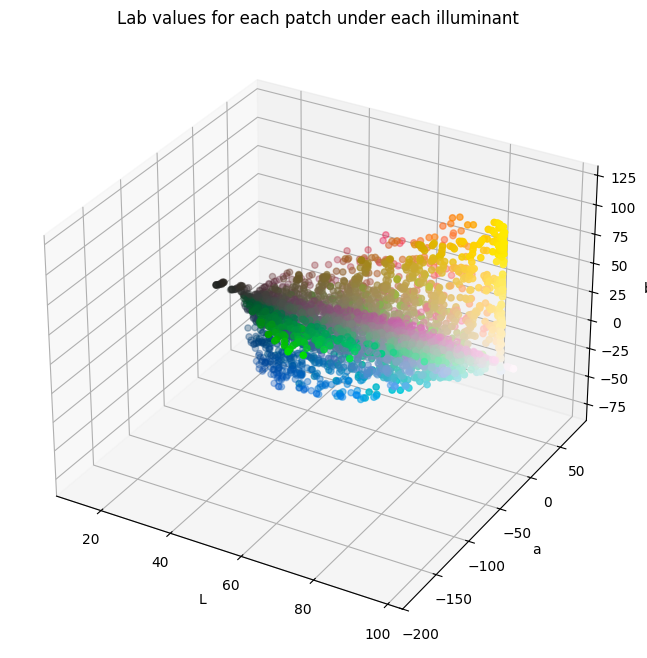

In [7]:
# Create a 3D figure with a larger size and higher DPI
fig = plt.figure(figsize=(12, 8), dpi=100)
ax = fig.add_subplot(111, projection='3d')

# Loop through each illuminant
for i in range(num_illuminants):
    rgb_colors = []
    # Loop through each patch to convert Lab -> sRGB for display
    for j in range(num_patches):
        lab = Lab_patches[i, j, :]  # [L, a, b]
        # Convert Lab to sRGB (using colorspacious)
        rgb = cs.cspace_convert(lab, "CIELab", "sRGB1")
        # Clip to the [0, 1] range to avoid invalid colors
        rgb = np.clip(rgb, 0, 1)
        rgb_colors.append(rgb)
    rgb_colors = np.array(rgb_colors)
    
    # Plot each set of points in Lab space, coloring them by their computed sRGB values
    ax.scatter(
        Lab_patches[i, :, 0],  # L values
        Lab_patches[i, :, 1],  # a values
        Lab_patches[i, :, 2],  # b values
        color=rgb_colors,
        label=f'Illuminant {i}'
    )

ax.set_xlabel('L')
ax.set_ylabel('a')
ax.set_zlabel('b')
ax.set_title('Lab values for each patch under each illuminant')

plt.show()

In [ ]:
fig = go.Figure()

# Loop through each illuminant
for i in range(num_illuminants):
    rgb_colors = []
    # Loop through each patch to convert Lab -> sRGB for display
    for j in range(num_patches):
        lab = Lab_patches[i, j, :]  # [L, a, b]
        # Convert Lab to sRGB (using colorspacious)
        rgb = cs.cspace_convert(lab, "CIELab", "sRGB1")
        # Clip to the [0, 1] range to avoid invalid colors
        rgb = np.clip(rgb, 0, 1)
        rgb_colors.append(rgb)
    rgb_colors = np.array(rgb_colors)
    
    # Plot each set of points in Lab space, coloring them by their computed sRGB values
    fig.add_trace(go.Scatter3d(
        x=Lab_patches[i, :, 0],  # L values
        y=Lab_patches[i, :, 1],  # a values
        z=Lab_patches[i, :, 2],  # b values
        mode='markers',
        marker=dict(
            color=rgb_colors,
        ),
        showlegend=False
    ))

fig.layout.scene.aspectratio = {'x':1, 'y':1, 'z':1}
fig.update_layout(
    autosize=False,
    width=800,
    height=800,
    title='Lab values for each patch under each illuminant',
    scene=dict(
        xaxis_title='L',
        yaxis_title='a',
        zaxis_title='b',
        aspectmode='cube'
    )
)

fig.show()

In [ ]:
# 5. Compute the delta_E_00 values for each patch under each illuminant

# Initialize the matrix for delta_E_00
mat_side_size = num_illuminants * num_patches
delta_E_00 = np.zeros((mat_side_size, mat_side_size))

# Define the function to compute h_prime
def h_prime_func(C1, h1, C2, h2):
    if abs(h1 - h2) <= np.pi and C1 * C2 != 0:
        return (h1 + h2) / 2
    elif abs(h1 - h2) > np.pi and (h1 + h2) < 2 * np.pi and C1 * C2 != 0:
        return (h1 + h2 + 2 * np.pi) / 2
    elif abs(h1 - h2) > np.pi and (h1 + h2) >= 2 * np.pi and C1 * C2 != 0:
        return (h1 + h2 - 2 * np.pi) / 2
    elif C1 * C2 == 0:
        return h1 + h2

# Define the function delta_E_00
def delta_E_00_func(LCh1, LCh2):
    # Computation of the CIEDE2000 color difference
    L_prime = (LCh1[0] + LCh2[0]) / 2
    C_prime = (LCh1[1] + LCh2[1]) / 2
    h_prime = h_prime_func(LCh1[1], LCh1[2], LCh2[1], LCh2[2])
    T = 1 - 0.17 * np.cos(h_prime - np.pi / 6) + 0.24 * np.cos(2 * h_prime) + 0.32 * np.cos(3 * h_prime + np.pi / 30) - 0.2 * np.cos(4 * h_prime - 63 * np.pi / 180)
    delta_theta = np.deg2rad(30) * np.exp(-((180 / np.pi * h_prime - 275) / 25) ** 2)
    R_C = 2 * np.sqrt(C_prime ** 7 / (C_prime ** 7 + 25 ** 7))
    S_L = 1 + (0.015 * (L_prime - 50) ** 2) / np.sqrt(20 + (L_prime - 50) ** 2)
    S_C = 1 + 0.045 * C_prime
    S_H = 1 + 0.015 * C_prime * T
    R_T = -np.sin(2 * delta_theta) * R_C
    delta_L_prime = LCh2[0] - LCh1[0]
    delta_C_prime = LCh2[1] - LCh1[1]
    delta_h_prime = 2 * np.sqrt(LCh1[1] * LCh2[1]) * np.sin((LCh2[2] - LCh1[2]) / 2)
    k_L = k_C = k_H = 1
    delta_E_00 = np.sqrt(
        (delta_L_prime / (k_L * S_L)) ** 2 +
        (delta_C_prime / (k_C * S_C)) ** 2 +
        (delta_h_prime / (k_H * S_H)) ** 2 +
        R_T * (delta_C_prime / (k_C * S_C)) * (delta_h_prime / (k_H * S_H))
    )
    return delta_E_00

# Compute delta_E_00 for each patch under each illuminant
for i in range(num_illuminants):
    for j in range(num_patches):
        for k in range(num_illuminants):
            for l in range(num_patches):
                index1 = i * num_patches + j
                index2 = k * num_patches + l
                if index1 != index2:
                    delta_E_00[index1, index2] = delta_E_00_func(LCh_patches[i, j, :], LCh_patches[k, l, :])

print("delta_E_00 : ", delta_E_00.shape)


In [ ]:
# 6. Find the most optimized patch couple

# Initialize the variables
min_delta_E = np.inf
max_delta_E = 0
min_pos = (0, 0)
max_pos = (0, 0)

# Find the most optimized patch couple
for i in range(num_illuminants):
    for j in range(num_illuminants):
        if i != j:
            for k in range(num_patches):
                index1 = i * num_patches + k
                index2 = j * num_patches + k
                if delta_E_00[index1, index2] < min_delta_E:
                    min_delta_E = delta_E_00[index1, index2]
                    min_pos = (index1, index2)
                if delta_E_00[index1, index2] > max_delta_E:
                    max_delta_E = delta_E_00[index1, index2]
                    max_pos = (index1, index2)

print("Min delta_E_00 : ", min_delta_E, " at position ", min_pos)
print("Max delta_E_00 : ", max_delta_E, " at position ", max_pos)

# 7. Display the most optimized patch couple, and the corresponding illuminants
print("Illuminant for min delta_E_00 : ", min_pos[0] // num_patches, " and ", min_pos[1] // num_patches)
print("Illuminant for max delta_E_00 : ", max_pos[0] // num_patches, " and ", max_pos[1] // num_patches)
print("Patch for min delta_E_00 : ", min_pos[0] % num_patches)
print("Patch for max delta_E_00 : ", max_pos[0] % num_patches)

Min delta_E_00 :  0.02076060963727794  at position  (2910, 3181)
Max delta_E_00 :  107.6051867446029  at position  (1992, 3333)
Illuminant for min delta_E_00 :  15
Illuminant for max delta_E_00 :  10
Patch for min delta_E_00 :  75
Patch for max delta_E_00 :  102


In [ ]:
# 6. Find the most optimized patch couple

# Initialize the variables
min_delta_E = np.inf
max_delta_E = 0
min_pos = (0, 0)
max_pos = (0, 0)

# Find the most optimized patch couple
for i in range(mat_side_size):
    for j in range(mat_side_size):
        if i != j:
            if delta_E_00[i, j] < min_delta_E:
                min_delta_E = delta_E_00[i, j]
                min_pos = (i, j)
            if delta_E_00[i, j] > max_delta_E:
                max_delta_E = delta_E_00[i, j]
                max_pos = (i, j)

print("Min delta_E_00 : ", min_delta_E, " at position ", min_pos)
print("Max delta_E_00 : ", max_delta_E, " at position ", max_pos)

# 7. Display the most optimized patch couple, and the corresponding illuminants
print("Illuminant for min delta_E_00 : ", min_pos[0] // num_patches)
print("Illuminant for max delta_E_00 : ", max_pos[0] // num_patches)
print("Patch for min delta_E_00 : ", min_pos[0] % num_patches)
print("Patch for max delta_E_00 : ", max_pos[0] % num_patches)